# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit, functools
from math import ceil

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


def Distance(X, Y):

    X_sum = (X ** 2).sum(axis=1).reshape(-1, 1).astype(np.float64)
    Y_sum = (Y ** 2).sum(axis=1).reshape(1, -1).astype(np.float64)
    XY = X.dot(Y.T).astype(np.float64)

    return X_sum - 2*XY + Y_sum

In [4]:
#%%pycodestyle


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', epsilon=1e-02):
        '''
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        '''

        self.k = k
        self.init = init
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.centroids = np.empty(1)
        self.epsilon = epsilon
        self.loss = epsilon + 1
        self.iteration = 0

    def init_centroids(self, X):
        '''
        Инициализация начального располодежия центроидов
        Алгоритм KMeans++
        '''

        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0],
                               size=self.k, replace=False)]
        elif self.init == 'k-means++':
            # Иницализация пустыми значениями (задаём размер)
            self.centroids = np.empty((self.k, X.shape[1]))

            # Начальный центроид выбирается случайно среди всех элеметов
            self.centroids[0] = X[np.random.randint(X.shape[0])]

            # Остальные центроиды выбривются из элеметов так, что
            # Вероятность выбора точки пропорциональна квадрату расстояния до
            # Ближайшего цетроида
            for i in range(1, self.k):
                nearest_distance = np.min(Distance(X, self.centroids[:i]),
                                          axis=1)
                probability = (nearest_distance /
                               (np.sum(nearest_distance).astype(np.float64)))
                probability[probability < 0] = 0
                self.centroids[i] = X[np.random.choice(X.shape[0],
                                                       p=probability)]
        else:
            raise 'Wrong init parametr'

    def update_centroids(self, X, labels, previous_centroids):
        '''
        Пересчёт коорднат цетроидов
        '''

        previous_centroids = np.array(previous_centroids)

        # Для новое значение цетроида вычисляется как среднее
        # По элеметам принадлежащим данному классу на текущем этапе
        for i in range(self.k):
            if (labels == i).sum() > 1e-5:
                self.centroids[i] = X[labels == i].sum(axis=0)
                self.centroids[i] /= (X[labels == i].shape[0])

        # Считаем функцию потерь как сумму
        # Изменение квадратов расстояний центроидов
        return ((previous_centroids - self.centroids) ** 2).sum()

    def fit(self, X, y=None):
        '''
        Процедура обучения k-means
        '''

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.init_centroids(X)

        while (self.loss > self.epsilon) and (self.iteration < self.max_iter):

            # Присваивание элемету его класс в
            # зависимости от расположения центроидов
            self.labels = np.argmin(Distance(X, self.centroids), axis=1)

            # Обновление координат центроидов
            self.loss = self.update_centroids(X, self.labels, self.centroids)

            self.iteration += 1

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        """

        return np.argmin(Distance(X, self.centroids), axis=1)


In [6]:
#%%pycodestyle


class MiniBatchMyKmeans(MyKmeans):

    def __init__(self, batch_size=32, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', epsilon=1e-02):

        # Вызываем "конструктор" базового класса
        super(MiniBatchKMeans, self).__init__(k=k, metric=metric,
                                              max_iter=max_iter,
                                              random_state=random_state,
                                              init=init, epsilon=epsilon)
        self.batch_size = batch_size
        self.batches = []

    def init_batches(self, X):
        '''
        Разделить данные на части примерно равных размеров self.batch_size
        '''

        # Перемешиваем индексы
        random_idx = np.random.choice(X.shape[0], size=X.shape[0],
                                      replace=False)

        # Разделяем перемешанные индексы на части
        for i in range(0, X.shape[0], self.batch_size):
            batch = random_idx[i: i + self.batch_size]
            self.batches.append(batch)

        # Последняя часть будет меньшего размера
        if (float(X.shape[0]) / self.batch_size > 1e-10):
            batch = random_idx[int(X.shape[0] /
                               self.batch_size) * self.batch_size:]
            self.batches.append(batch)

    def fit(self, X):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.init_centroids(X)

        # Разбиваем данные на части
        self.init_batches(X)

        # Количество батчей
        batch_count = ceil(float(X.shape[0]) / self.batch_size)

        while (self.loss > self.epsilon) and (self.iteration < self.max_iter):

            # Присваивание элемету его класс в
            # зависимости от расположения центроидов
            self.labels = np.argmin(Distance(X, self.centroids), axis=1)

            elements = self.batches[int(self.iteration % batch_count)]

            # Обновление координат центроидов
            self.loss = self.update_centroids(X[elements],
                                              self.labels[elements],
                                              self.centroids)
            self.iteration += 1

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [7]:
from sklearn.datasets import make_blobs

In [11]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
                  center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

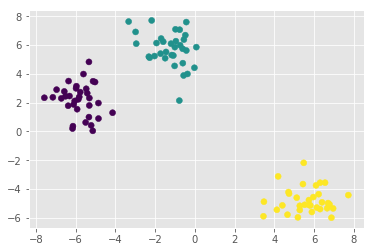

In [12]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

Loss: 0.0, Iterations: 5.


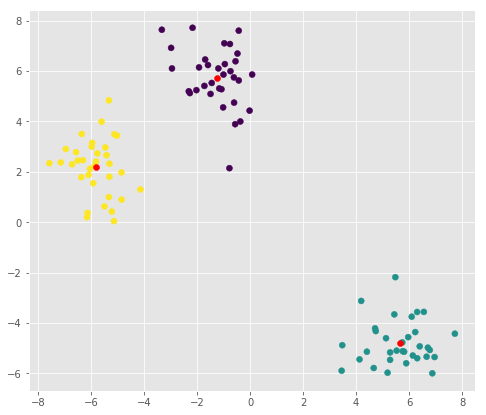

In [13]:
## Работоспособность MyKmeans

model = MyKmeans(k=3, epsilon=1e-3, max_iter=1e4, init='random')
model.fit(X)

print('Loss: {}, Iterations: {}.'.format(model.loss, model.iteration))

y = model.predict(X)

plt.figure(figsize=(8, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='r')
plt.show()

Loss: 0.0, Iterations: 3.


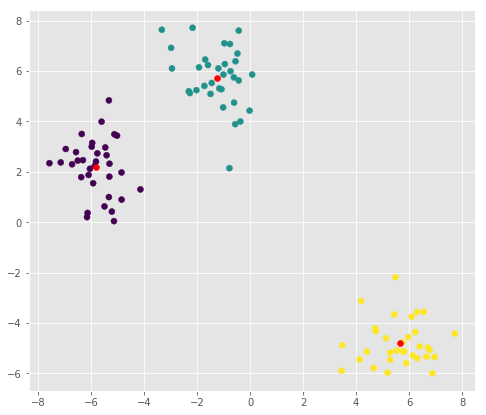

In [14]:
## Работоспособность MyKmeans++

model = MyKmeans(k=3, epsilon=1e-2, max_iter=1e4, init='k-means++')
model.fit(X)

print('Loss: {}, Iterations: {}.'.format(model.loss, model.iteration))

y = model.predict(X)
plt.figure(figsize=(8, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='r')
plt.show()

Loss: 0.5542407456983928, Iterations: 10000.


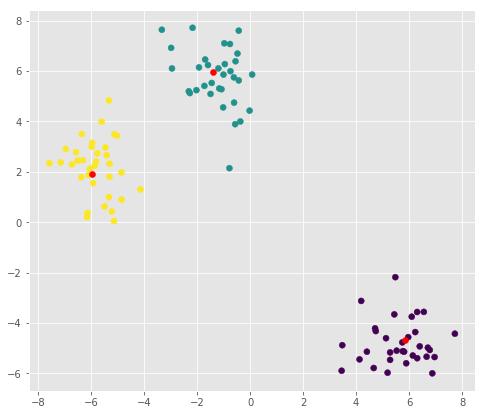

In [18]:
## Работоспособность MyKmeans с MiniBatchMyKmeans

model = MiniBatchMyKmeans(k=3, epsilon=1e-2, max_iter=1e4,
                        init='random', batch_size=62)
model.fit(X)

print('Loss: {}, Iterations: {}.'.format(model.loss, model.iteration))

y = model.predict(X)
plt.figure(figsize=(8, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='r')
plt.show()

Loss: 1.109921963012137, Iterations: 10000.


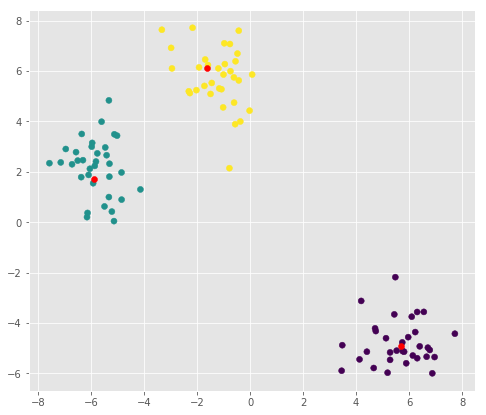

In [19]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans

model = MiniBatchMyKmeans(k=3, epsilon=1e-2, max_iter=1e4,
                        init='k-means++', batch_size=64)
model.fit(X)

print('Loss: {}, Iterations: {}.'.format(model.loss, model.iteration))

y = model.predict(X)

plt.figure(figsize=(8, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='r')
plt.show()

In [20]:
from sklearn.cluster import KMeans

In [21]:
## Время выполнения алгоритма Kmeans из sklearn
model = KMeans(n_clusters=3, init='random', max_iter=1e3)

In [22]:
%%timeit
model.fit(X)

24.9 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
## Время выполнения алгоритма MyKmeans

model = MyKmeans(k=3, epsilon=1e-1, max_iter=1e4, init='random')

In [24]:
%%timeit
model.fit(X)

222 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
## Время выполнения алгоритма MyKmeans++
model = MyKmeans(k=3, epsilon=1e-1, max_iter=1e4, init='k-means++')

In [26]:
%%timeit
model.fit(X)

775 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
model = MiniBatchMyKmeans(k=3, epsilon=1e-1, max_iter=1e4, init='random')

In [28]:
%%timeit
model.fit(X)

368 µs ± 70.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
model = MiniBatchMyKmeans(k=3, epsilon=1e-1, max_iter=1e4, init='k-means++')

In [30]:
%%timeit
model.fit(X)

875 µs ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Функция вызова настройки модели
def fit_model(model, X):
    return model.fit(X)

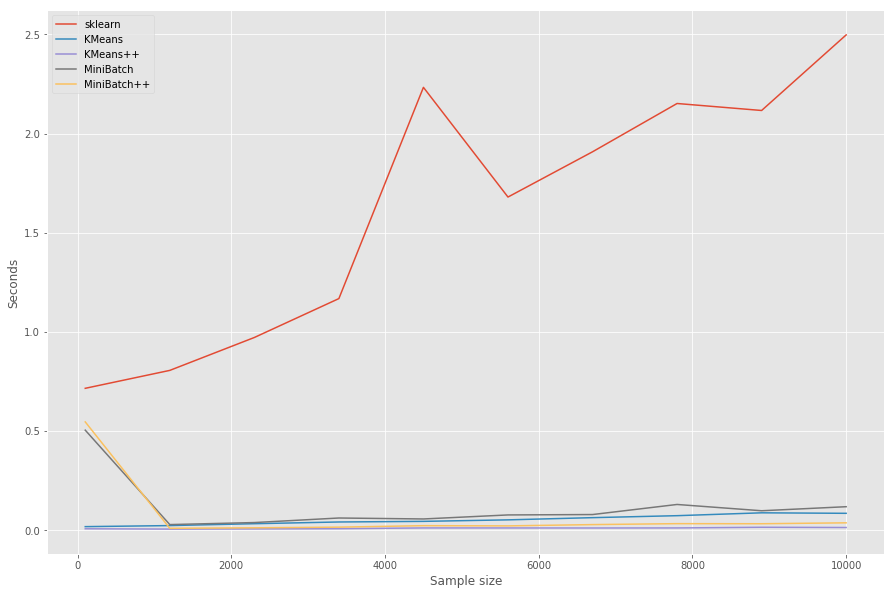

In [34]:
# Массив из размеров данных
sample_sizes = np.linspace(1e2, 1e4, 10, dtype=int)

# Модели для сравнения
model_names = ['sklearn', 'k-means', 'k-means++', 'MiniBatch', 'MiniBatch++']

# Количество кластеров и кол-во запусков на одних данных
n_clusters = 3
launch_times = 20

# Словарь из моделей
models = dict()
models['sklearn'] = KMeans(n_clusters=n_clusters)
models['KMeans'] = MyKmeans(k=n_clusters, init='k-means++')
models['KMeans++'] = MyKmeans(k=n_clusters, init='random')
models['MiniBatch'] = MiniBatchMyKmeans(k=n_clusters, init='k-means++')
models['MiniBatch++'] = MiniBatchMyKmeans(k=n_clusters, init='random')

# Словарь времени тренировки каждой модели (пустой)
time = dict()
for model in models:
    time[model] = list()

for n_samples in sample_sizes:

    # Генерация данных
    X, y = make_blobs(n_samples=n_samples, n_features=4, centers=3)

    # Вызов таймера для каждой модели
    for model in models:
        # Создание объекта класса Timer, которыей измеряет конкретную модель
        t = timeit.Timer(functools.partial(fit_model, models[model], X))

        # Запуск таймера и добавление результата в лист
        time[model].append(t.timeit(launch_times))

plt.figure(figsize=(15, 10))

for model in models:
    plt.plot(sample_sizes, time[model], label=model)

plt.xlabel('Sample size')
plt.ylabel('Seconds')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [37]:
df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1, inplace=True)
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [38]:
# Преобразую данные в numpy матрицу
features = np.array(list(df_sns))
data = df_sns.values.astype(np.float64)

X = StandardScaler().fit_transform(data)

In [39]:
def Describe_cluster(labels, features, centroids, k=5):
    '''
    Описание класетров
    '''

    cluster_features = features[(np.argsort(-centroids, axis=1))[:, :k]]

    for i in range(np.unique(labels).size):
        cluster_size = labels[labels == i].size
        print('Cluster #{} size: {}'.format(i, cluster_size))
        print(('Top {} important words: ' +
               ', '.join(cluster_features[i]) + '\n').format(k))

In [40]:
## MyKmeans

model = MyKmeans(k=9, epsilon=1e-2, max_iter=1e5, init='random')
model.fit(X)
labels = model.predict(X)

print('Loss: {}, Iterations: {}.\n'.format(model.loss, model.iteration))
Describe_cluster(labels, features, model.centroids)

Loss: 0.008219565899718504, Iterations: 30.

Cluster #0 size: 19644
Top 5 important words: blonde, tennis, jesus, death, bible

Cluster #1 size: 910
Top 5 important words: kissed, drugs, hair, sex, drunk

Cluster #2 size: 450
Top 5 important words: bible, jesus, god, church, death

Cluster #3 size: 747
Top 5 important words: marching, band, music, rock, god

Cluster #4 size: 491
Top 5 important words: swimming, shopping, music, clothes, mall

Cluster #5 size: 3824
Top 5 important words: cute, shopping, dance, dress, mall

Cluster #6 size: 831
Top 5 important words: hollister, abercrombie, shopping, mall, clothes

Cluster #7 size: 2462
Top 5 important words: basketball, football, softball, baseball, sports

Cluster #8 size: 641
Top 5 important words: cheerleading, shopping, football, cute, hot



In [41]:
%%timeit

model = MyKmeans(k=9, epsilon=1e-2, max_iter=1e5, init='random')
model.fit(X)

2.51 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
## MyKmeans++

model = MyKmeans(k=9, epsilon=1e-2, max_iter=1e5, init='k-means++')
model.fit(X)
labels = model.predict(X)

print('Loss: {}, Iterations: {}.\n'.format(model.loss, model.iteration))
Describe_cluster(labels, features, model.centroids)

Loss: 0.00898361471433094, Iterations: 23.

Cluster #0 size: 19537
Top 5 important words: blonde, tennis, jesus, bible, sexy

Cluster #1 size: 486
Top 5 important words: marching, band, music, rock, football

Cluster #2 size: 3962
Top 5 important words: shopping, cute, mall, dress, dance

Cluster #3 size: 283
Top 5 important words: kissed, sex, hair, drugs, rock

Cluster #4 size: 853
Top 5 important words: hollister, abercrombie, shopping, mall, clothes

Cluster #5 size: 2350
Top 5 important words: football, basketball, baseball, sports, soccer

Cluster #6 size: 1553
Top 5 important words: drunk, drugs, die, hair, kissed

Cluster #7 size: 499
Top 5 important words: softball, basketball, volleyball, sports, shopping

Cluster #8 size: 477
Top 5 important words: bible, jesus, god, church, death



In [43]:
%%timeit

model = MyKMeans(k=9, epsilon=1e-2, max_iter=1e5, init='k-means++')
model.fit(X)

2.78 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
## MyKmeans с MiniBatchMyKmeans

model = MiniBatchMyKmeans(k=9, epsilon=1e-2, max_iter=1e3,
                        init='random', batch_size=8000)
model.fit(X)
labels = model.predict(X)

print('Loss: {}, Iterations: {}.\n'.format(model.loss, model.iteration))
Describe_cluster(labels, features, model.centroids)

Loss: 11.572615477349077, Iterations: 1000.

Cluster #0 size: 834
Top 5 important words: hollister, abercrombie, shopping, mall, cute

Cluster #1 size: 4045
Top 5 important words: cute, shopping, dress, mall, dance

Cluster #2 size: 1223
Top 5 important words: drunk, drugs, die, hair, kissed

Cluster #3 size: 574
Top 5 important words: marching, band, music, church, god

Cluster #4 size: 235
Top 5 important words: kissed, sex, rock, hair, music

Cluster #5 size: 521
Top 5 important words: bible, jesus, god, church, death

Cluster #6 size: 2253
Top 5 important words: basketball, baseball, softball, football, sports

Cluster #7 size: 19685
Top 5 important words: blonde, tennis, soccer, jesus, swimming

Cluster #8 size: 630
Top 5 important words: cheerleading, shopping, football, hot, hollister



In [45]:
%%timeit

model = MiniBatchKMeans(k=9, epsilon=1e-2, max_iter=1e3,
                        init='random', batch_size=8000)
model.fit(X)

52.9 s ± 11.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
## MyKmeans++ с MiniBatchMyKmeans

model = MiniBatchMyKmeans(k=9, epsilon=1e-2, max_iter=1e3,
                        init='k-means++', batch_size=8000)
model.fit(X)

labels = model.predict(X)

print('Loss: {}, Iterations: {}.\n'.format(model.loss, model.iteration))

Describe_cluster(labels, features, model.centroids)

Loss: 10.16599840548997, Iterations: 1000.

Cluster #0 size: 20952
Top 5 important words: blonde, tennis, jesus, bible, soccer

Cluster #1 size: 1
Top 5 important words: blonde, sex, drunk, death, hair

Cluster #2 size: 852
Top 5 important words: abercrombie, hollister, shopping, mall, clothes

Cluster #3 size: 493
Top 5 important words: marching, band, music, rock, football

Cluster #4 size: 5687
Top 5 important words: shopping, cute, dance, mall, dress

Cluster #5 size: 373
Top 5 important words: drunk, hair, sexy, kissed, sex

Cluster #6 size: 214
Top 5 important words: bible, jesus, god, church, drugs

Cluster #7 size: 567
Top 5 important words: baseball, basketball, football, sports, rock

Cluster #8 size: 861
Top 5 important words: drugs, kissed, hair, sex, die



In [47]:
%%timeit

model = MiniBatchMyKmeans(k=9, epsilon=1e-2, max_iter=1e3,
                        init='k-means++', batch_size=8000)
model.fit(X)

53.4 s ± 10.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Вывод

KMeans++ ускоряет модель и снижает вероятность найти локальный минимум, при этом не требует большой вычислительной мощности

MiniBatch не ускоряет модель, поскльку точность уменьшатеся медленнее, и для достижениия нужно точности требуется больше времени, чем KMeans. Однако даёт возможность работать с большими объёмами данных.

Поэтому выбор модели (использование MiniBatch) зависит от объёма данных, усовершенствованную инициализацию центроидов (k-means++) рекомендуется использовать всегода.